In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [45]:
rerun = True
filename_end = "_3"
folder_name = "files/"

In [46]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]
print(ws, t2s, M_0s)

spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


[2355.21183064] [0.0199] [0.2917]
All frequencies are captured by the sampling rate.


In [47]:
sigma = 0.001

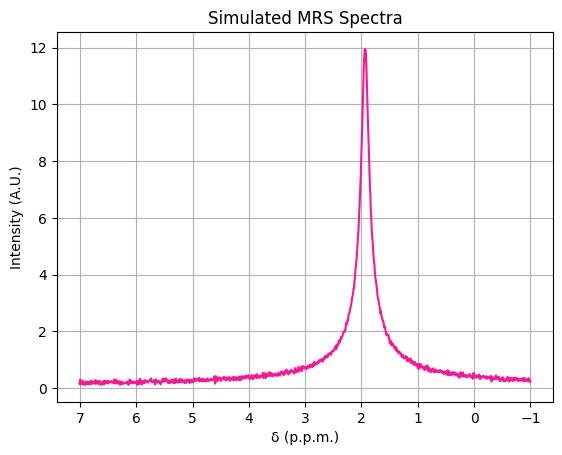

In [48]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, sigma)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [49]:
L = 0.4
noise_threshold = 1e-30

In [50]:
reconstructed_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True)

In [51]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2 = 1/alpha

(-500.0, 500.0)

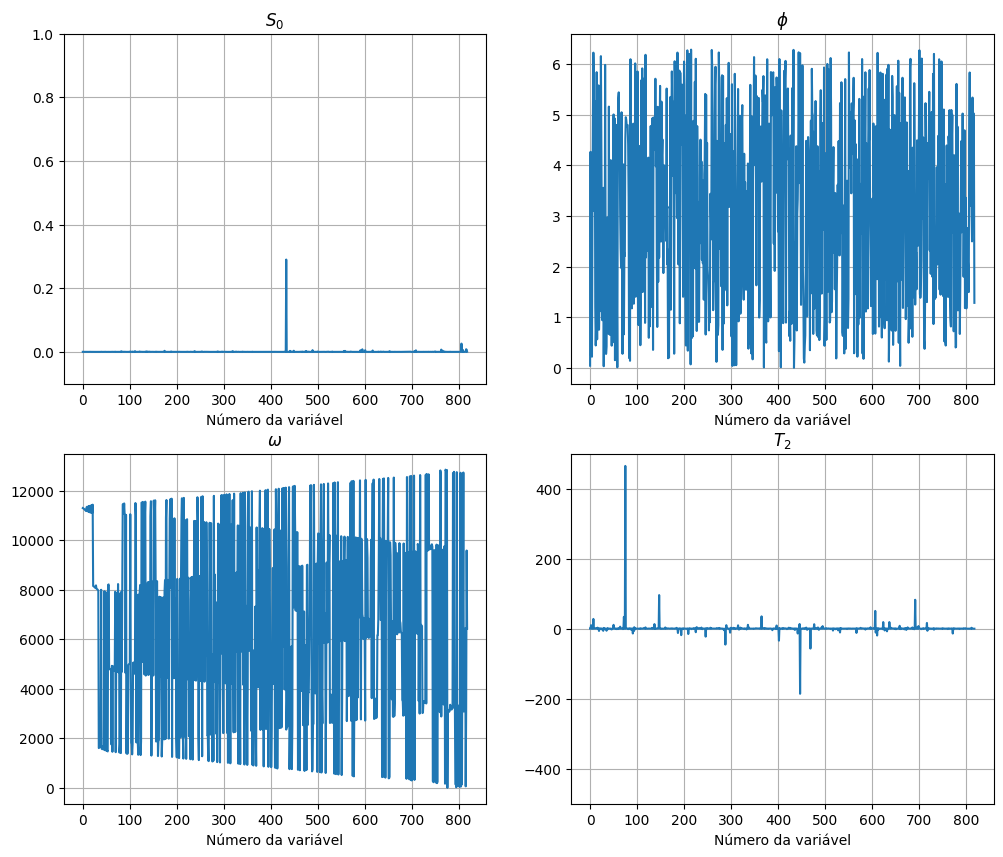

In [52]:
i = np.arange(0, omega.size, 1)


plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.plot(i, s0)
plt.title(r"$S_0$")
plt.xlabel("Número da variável")
plt.grid()
plt.ylim(-0.1, 1.0)

plt.subplot(222)
plt.plot(i, phi)
plt.title(r"$\phi$")
plt.xlabel("Número da variável")
plt.grid()

plt.subplot(223)
plt.plot(i, omega)
plt.title(r"$\omega$")
plt.xlabel("Número da variável")
plt.grid()
# ax[1, 0].legend()

plt.subplot(224)
plt.plot(i, t2)
plt.title(r"$T_2$")
plt.xlabel("Número da variável")
plt.grid()
plt.ylim(-500, 500)

In [53]:
sigma = np.arange(0.0, 0.04, 0.001)
snrs = np.zeros_like(sigma)

s0_arr = np.zeros((sigma.size, s0.size))
phi_arr = np.zeros((sigma.size, s0.size))
omega_arr = np.zeros((sigma.size, s0.size))
t2_arr = np.zeros((sigma.size, s0.size))

In [54]:
if rerun == True:
    for i in range(sigma.size):
        c_sig = pymri.corrupted_snr(sig, 0.0, sigma[i])

        r_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
        snrs[i] = pymri.snr(r_sig)
        s0_arr[i, :], phi_arr[i, :], omega_arr[i, :], t2_arr[i, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
        t2_arr[i, :] = 1/t2_arr[i, :]

In [55]:
subfolder_name = "single_peak/"
if rerun == True:
    file = open(folder_name + subfolder_name + "s0_arr" + filename_end + ".csv", "w")
    file.write(",".join(str(x) for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in s0_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "phi_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in phi_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "omega_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in omega_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "t2_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in t2_arr[i, :]) + "\n")
    file.close()
    

In [56]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + subfolder_name + "s0_arr" + filename_end + ".csv")
    s0_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "phi_arr" + filename_end + ".csv")
    phi_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "omega_arr" + filename_end + ".csv")
    omega_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "t2_arr" + filename_end + ".csv")
    t2_arr = file_in.values


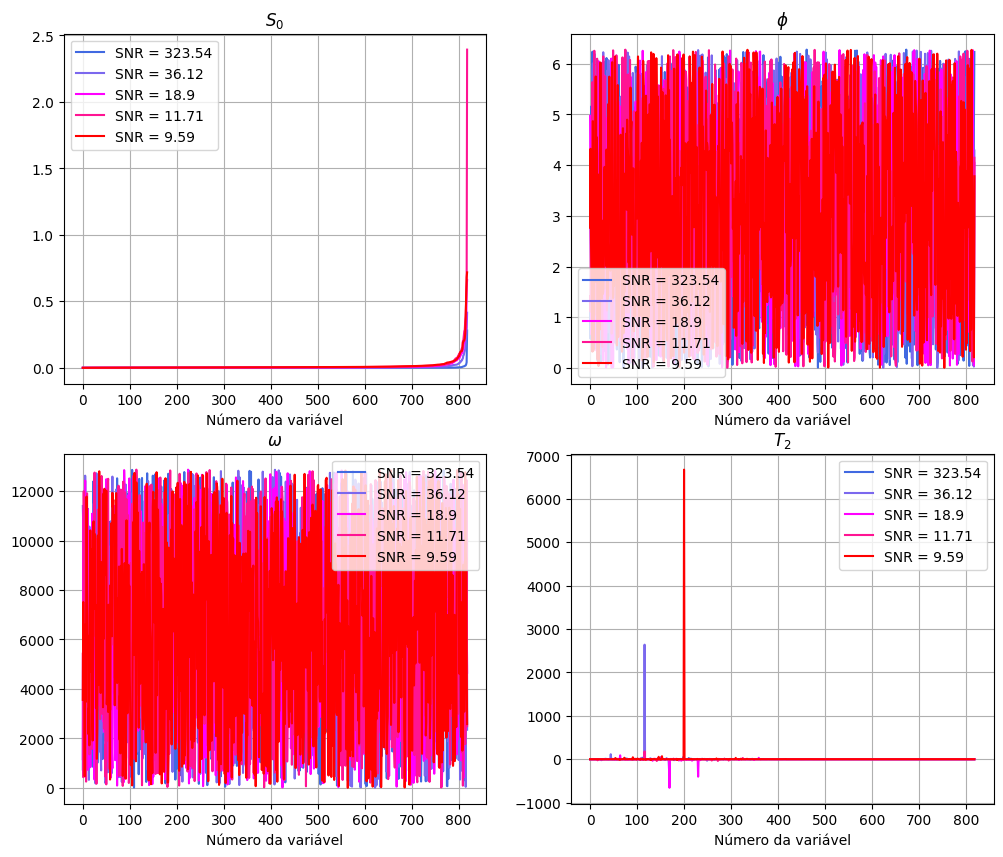

In [58]:
i = np.arange(0, omega.size, 1)

frame = 1
frames = np.linspace(1, sigma.size -1, 5, dtype = int)
colors = ["royalblue", "mediumslateblue", "magenta", "deeppink", "red"]
plt.figure(figsize=(12, 10))


for j in range(frames.size):
    sort_arr = np.argsort(s0_arr[frames[j], :])

    plt.subplot(221)
    plt.plot(i, s0_arr[frames[j],:][sort_arr], c = colors[j], label = f"SNR = {round(snrs[frames[j]], 2)}")
    plt.title(r"$S_0$")
    plt.xlabel("Número da variável")
    plt.legend()
    plt.grid()

    plt.subplot(222)
    plt.plot(i, phi_arr[frames[j],:][sort_arr], c = colors[j], label = f"SNR = {round(snrs[frames[j]], 2)}")
    plt.title(r"$\phi$")
    plt.xlabel("Número da variável")
    plt.legend()
    plt.grid()

    plt.subplot(223)
    plt.plot(i, omega_arr[frames[j],:][sort_arr], c = colors[j], label = f"SNR = {round(snrs[frames[j]], 2)}")
    plt.title(r"$\omega$")
    plt.xlabel("Número da variável")
    plt.legend()
    plt.grid()

    plt.subplot(224)
    plt.plot(i, t2_arr[frames[j],:][sort_arr], c = colors[j], label = f"SNR = {round(snrs[frames[j]], 2)}")
    plt.title(r"$T_2$")
    plt.xlabel("Número da variável")
    plt.legend()
    plt.grid()